In [10]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import Perceptron
from deslib.static import Oracle
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sgh import SGH

In [11]:
dataset_dir = 'datasets/'
df = pd.read_csv(dataset_dir + 'epileptic_seizure.csv', sep=',')
df.columns.values[0] = "Intance_name"
df['y'] += -1

Text(0, 0.5, 'Frequency')

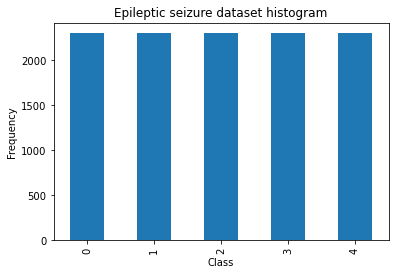

In [12]:
count_classes = pd.value_counts(df['y'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Epileptic seizure dataset histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [13]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
y = df['y']
X = df.drop(labels=['y','Intance_name'], axis=1)
X = pd.DataFrame(ss.fit_transform(X),columns = X.columns)

In [14]:
def oracle_for_random_subspace(meta_model, X_test, y_test):
    base_models = meta_model.estimators_
    base_models_feats = meta_model.estimators_features_

    base_models_preds = []
    for i in range(len(base_models)):
        X_test_subspace = X_test.iloc[:,base_models_feats[i]] #selecting only the columns used for the ith base model.
        y_pred = base_models[i].predict(X_test_subspace)
        base_models_preds.append(y_pred)

    oracle_hits = []
    for i in range(len(y_test)):
        oracle_hit = 0
        for j in range(len(base_models_preds)):
            if base_models_preds[j][i] == y_test[i]:
                oracle_hit = 1
                break
        oracle_hits.append(oracle_hit)

    oracle_score = np.sum(oracle_hits)/len(oracle_hits)
    #print('Oracle score = ', oracle_score)
    return oracle_score

In [15]:
from dataclasses import dataclass
import random
from sklearn.metrics.pairwise import euclidean_distances
import collections
from collections import Counter

class dumb_base:
    classe: int   
        
    def __init__(self, value):
        self.classe = value
        
    
    def predict(self,X_test):
        saida = []
        for index in range(len(X_test)):
            saida.append(self.classe)
        
        return saida


class clf_base_r:
    clf_1: Perceptron
    clf_2: Perceptron
    h: KMeans   
        
    def __init__(self):
        self.clf_1 = Perceptron()
        self.clf_2 = Perceptron()
        self.h = KMeans
        
    
    def predict(self,X_test):
        saida = []
        for index, row in X_test.iterrows():
            dim = self.h.predict([row])[0]
            #print('kmeasn dim',dim)
            if(dim == 0):
                saida.append(self.clf_1.predict([row])[0])
            else:
                saida.append(self.clf_2.predict([row])[0])
        
        return saida
        
    def fit(self,X_train, y_train):
        
        self.h = KMeans(n_clusters=2, n_init=1, max_iter=1).fit(X_train)
         
        k_selection = self.h.predict(X_train)
        
        base1 =  []
        y1 = []
        
        base2 =  []
        y2 = []
                
        for index, d1 in enumerate(k_selection):
            if(d1 == 0):
                base1.append(X_train.iloc[index])
                y1.append(y_train[index])
            else:
                base2.append(X_train.iloc[index])
                y2.append(y_train[index])                
        
        base1 = pd.DataFrame(base1,columns=X_train.columns)
        base2 = pd.DataFrame(base2,columns=X_train.columns)
        if len(Counter(y1).keys()) >1:
            self.clf_1.fit(base1,y1)
        else:
             self.clf_1 = dumb_base(y1[0])
        if len(Counter(y2).keys()) >1:
            self.clf_2.fit(base2,y2)
        else:
             self.clf_2 = dumb_base(y2[0])
        
        return self

    
class random_linear_oracle:
    n_: int
    pool_classifiers: []
        
        
    def __init__(self, n_value=10):
        self.n_ = n_value
        self.pool_classifiers = []
        
        for x in range(self.n_):            
            self.pool_classifiers.append(clf_base_r())
    
    def fit(self,X_train, y_train):
        for x in range(self.n_): 
            self.pool_classifiers[x] = self.pool_classifiers[x].fit(X_train, y_train)
        return self
    
    def predict(self,X_test):
        saidas = []
        for x in range(self.n_): 
            saidas.append(self.pool_classifiers[x].predict(X_test))                
        
        saidas_clfs = [list(x) for x in zip(*saidas)]
        saida = []
        for v in saidas_clfs:
            occurence_count = Counter(v) 
            saida.append(occurence_count.most_common(1)[0][0])
        

        return saida
    
    def oracle(self,X_test, y_test):
        saidas = []
        for x in range(self.n_): 
            saidas.append(self.pool_classifiers[x].predict(X_test))                
        
        saidas_clfs = [list(x) for x in zip(*saidas)]
        hits = 0;
        for index, v in enumerate(saidas_clfs):
             if(y_test[index] in v):
                hits = hits + 1
        

        return hits/len(y_test)


In [8]:
def run_experiment():
    n_estimators_list = [10,20,40,60,80,100]
    kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

    for qtd_estimators in  n_estimators_list:
        print(qtd_estimators)
        bagging_oracle  = []
        adaboost_oracle = []
        randomsubspace_oracle = [] 
        randomlinearoracle_oracle = []

        for train_index, test_index in kf.split(X,y):

            pool_bagging  = BaggingClassifier(base_estimator=Perceptron(),n_estimators=qtd_estimators, random_state=42)
            pool_adaboost  = AdaBoostClassifier(base_estimator=CalibratedClassifierCV(Perceptron()),n_estimators=qtd_estimators,  random_state=42)
            pool_randomsubspace  = BaggingClassifier(base_estimator=Perceptron(),n_estimators=qtd_estimators,max_features=0.5,bootstrap=False, random_state=42)
            pool_random_oracle = random_linear_oracle(n_value=qtd_estimators)


            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            pool_bagging.fit(X_train,y_train)
            pool_adaboost.fit(X_train,y_train)
            pool_randomsubspace.fit(X_train,y_train) 
            pool_random_oracle.fit(X_train, y_train.values)


            oracle_bagging = Oracle(pool_bagging).fit(X_train, y_train)           
            bagging_oracle.append(oracle_bagging.score(X_test,y_test.values))


            oracle_adaboost = Oracle(pool_adaboost).fit(X_train, y_train)         
            adaboost_oracle.append(oracle_adaboost.score(X_test,y_test.values))

            randomsubspace_oracle.append(oracle_for_random_subspace(pool_randomsubspace, X_test, y_test.values))

            randomlinearoracle_oracle.append(pool_random_oracle.oracle(X_test, y_test.values))



        models_score = [bagging_oracle,adaboost_oracle,randomsubspace_oracle, randomlinearoracle_oracle]

        algoritmos = {'model': ['bagging_oracle','adaboost_oracle','randomsubspace_oracle','randomlinearoracle_oracle'],
            'mean': np.mean(models_score, axis=1),
            'std': np.std(models_score, axis=1)
            }

        df = pd.DataFrame(algoritmos, columns = ['model', 'mean', 'std'])


        #print(df)
        df.to_csv('model_score_'+str(qtd_estimators)+'_estimators', index=False)  
#run_experiment()    

In [ ]:
def erros_count_class(y_predict,y_test):
    classes_count = [0] * len(set(y_test))  
    
    for index, y in enumerate(y_predict):
        if(y != y_test[index]):
            classes_count[y_test[index]] += 1

    return classes_count

kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

sgh_oracle  = []
hyperplanes_count = [] 
erros_count = []

for train_index, test_index in kf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    pool_sgh = SGH()
    pool_sgh.fit(X_train.values,y_train.values)    
    oracle_sgh = Oracle(pool_sgh).fit(X_train, y_train) 
    
    sgh_oracle.append(oracle_sgh.score(X_test,y_test.values))
    hyperplanes_count.append(pool_sgh.hyperplanes)
    erros_count.append(erros_count_class(oracle_sgh.predict(X_test,y_test.values),y_test.values))

In [10]:
print("mean_oracle:", np.mean(sgh_oracle ))
print("std_oracle:", np.std(sgh_oracle ))

print("mean erros_count:", np.mean(erros_count, axis=0))
print("std erros_count:", np.std(erros_count, axis=0))

print("hyperplanes mean", np.mean(hyperplanes_count, axis=0))
print("hyperplanes std", np.std(hyperplanes_count, axis=0)) 
    

mean_oracle: 0.998695652173913
std_oracle: 0.0006735623210795382
mean erros_count: [1.  0.  0.8 0.8 0.4]
std erros_count: [1.09544512 0.         1.16619038 0.74833148 0.48989795]
hyperplanes mean [6.6 5.2 6.2 5.2 4. ]
hyperplanes std [1.0198039  1.46969385 2.03960781 0.74833148 0.89442719]
